# ZCTA modelling

## Model then push forward

This script proceeds in four steps:

1. Fit a tract-level model of infogroup bias reduction using 2010 data
2. Project the model to all available years 
3. Construct 5-year average adjusted estimates
4. Compare 5-year average adjusted estimates to ACS

---

### Setup

In [1]:
suppressPackageStartupMessages({
    library(tidyverse)
    library(lme4)
    library(brms)
    library(patchwork)
    library(parallel)
    library(gtools)
    library(ggridges)
})

In [2]:
source("../functions/utils.R")

In [3]:
dec <- readRDS("../data/prepped_data/zctas_decennial.rds")
acs_5 <- readRDS("../data/prepped_data/zctas_acs.rds")

In [4]:
names(dec) <- sub("_$", "", names(dec))
names(acs_5) <- sub("_$", "", names(acs_5))
dec <- dec %>% rename("stateid" = "state_fips")
acs_5 <- acs_5 %>% rename("stateid" = "state_fips")
dec$year <- as.numeric(dec$year)
acs_5$year <- as.numeric(acs_5$year)

In [5]:
n_cores <- detectCores() - 1
n_cores

[1] 7

---

### Fit Model

In [6]:
# Formula
desc1 <- "Bayesian random slopes with covariates"
f1 <- formula(log(chh) ~ 1 + log(ig_count_imptd) + (1 + log(ig_count_imptd) | stateid) +
              pown + pfemale + page_1824 + page_under18 + page_65plus + pnw + pblack + 
              phisp + pasian + pnative + pvacant + phu_othervacant + pgq)

formulas <- list(f1)

In [7]:
# Set Bayesian priors here
my_prior <- c(
    set_prior("normal(0, 5)", class = "Intercept"),
    set_prior("normal(0, 5)", class = "b"),
    set_prior("student_t(3, 0, 5)", class = "sd"),
    set_prior("lkj(2)", class = "cor")
)

In [8]:
# STAN code
print(make_stancode(f1, dec, prior = my_prior))

// generated with brms 2.14.4
functions {
  /* turn a vector into a matrix of defined dimension 
   * stores elements in row major order
   * Args: 
   *   X: a vector 
   *   N: first dimension of the desired matrix
   *   K: second dimension of the desired matrix 
   * Returns: 
   *   a matrix of dimension N x K 
   */ 
  matrix as_matrix(vector X, int N, int K) { 
    matrix[N, K] Y; 
    for (i in 1:N) {
      Y[i] = to_row_vector(X[((i - 1) * K + 1):(i * K)]); 
    }
    return Y; 
  } 
 /* compute correlated group-level effects
  * Args: 
  *   z: matrix of unscaled group-level effects
  *   SD: vector of standard deviation parameters
  *   L: cholesky factor correlation matrix
  * Returns: 
  *   matrix of scaled group-level effects
  */ 
  matrix scale_r_cor(matrix z, vector SD, matrix L) {
    // r is stored in another dimension order than z
    return transpose(diag_pre_multiply(SD, L) * z);
  }
}
data {
  int<lower=1> N;  // total number of observations
  vector[N] Y;  // r

In [9]:
# Rerunning this model can take several hours To rerun it, 
# delete the model file or set a different path in fit_models()
models <- fit_models(
    formulas, 
    dec, 
    "../models/zcta/zcta_final.rds", 
    cores = n_cores,
    prior = my_prior,
    chains = 6,
    iter = 6000,
    warmup = 1000,
    thin = 3
)

Fitting model 1

Model fit complete. Runtime:  0.5765338

In [10]:
summary(models[[1]])

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: log(chh) ~ log(ig_count_imptd) + (1 + log(ig_count_imptd) | stateid) + pown + pfemale + page_1824 + page_under18 + page_65plus + pnw + pblack + phisp + pasian + pnative + pvacant + phu_othervacant + pgq 
   Data: data (Number of observations: 32369) 
Samples: 6 chains, each with iter = 6000; warmup = 1000; thin = 3;
         total post-warmup samples = 10000

Group-Level Effects: 
~stateid (Number of levels: 51) 
                                 Estimate Est.Error l-95% CI u-95% CI Rhat
sd(Intercept)                        0.38      0.04     0.31     0.47 1.00
sd(logig_count_imptd)                0.04      0.00     0.03     0.05 1.00
cor(Intercept,logig_count_imptd)    -0.98      0.01    -0.99    -0.97 1.00
                                 Bulk_ESS Tail_ESS
sd(Intercept)                        5259     7695
sd(logig_count_imptd)                5380     7624
cor(Intercept,logig_count_imptd)     6999     8845

Populati

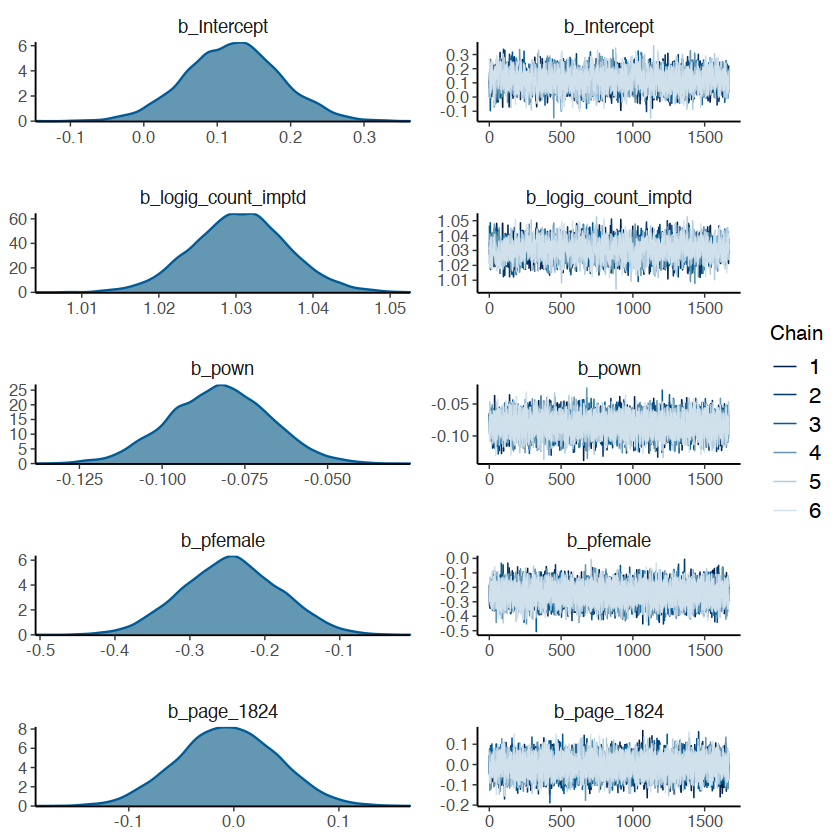

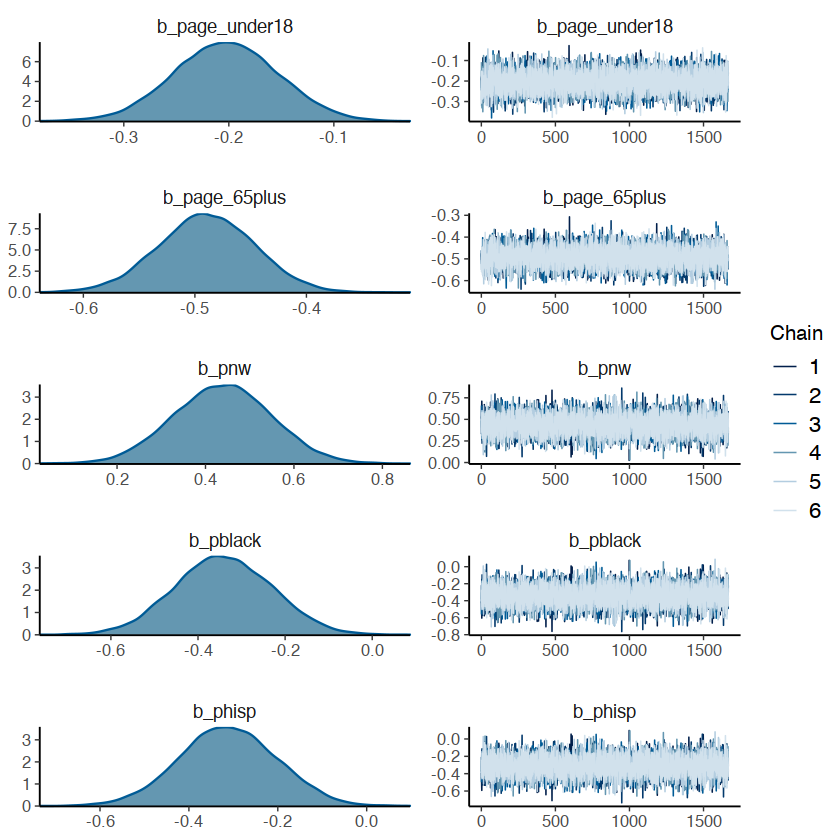

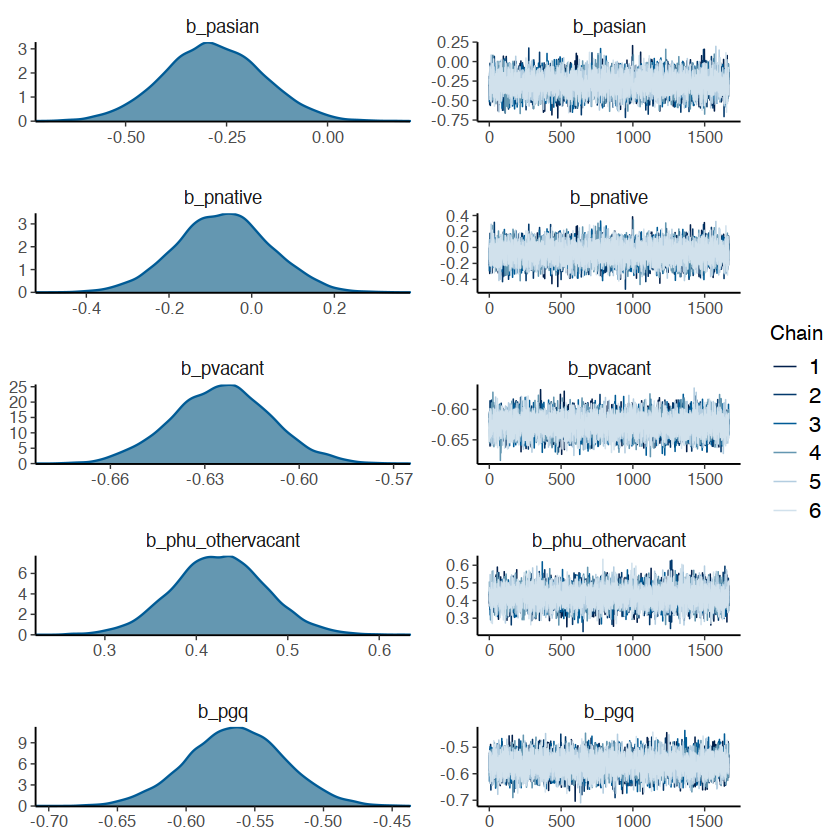

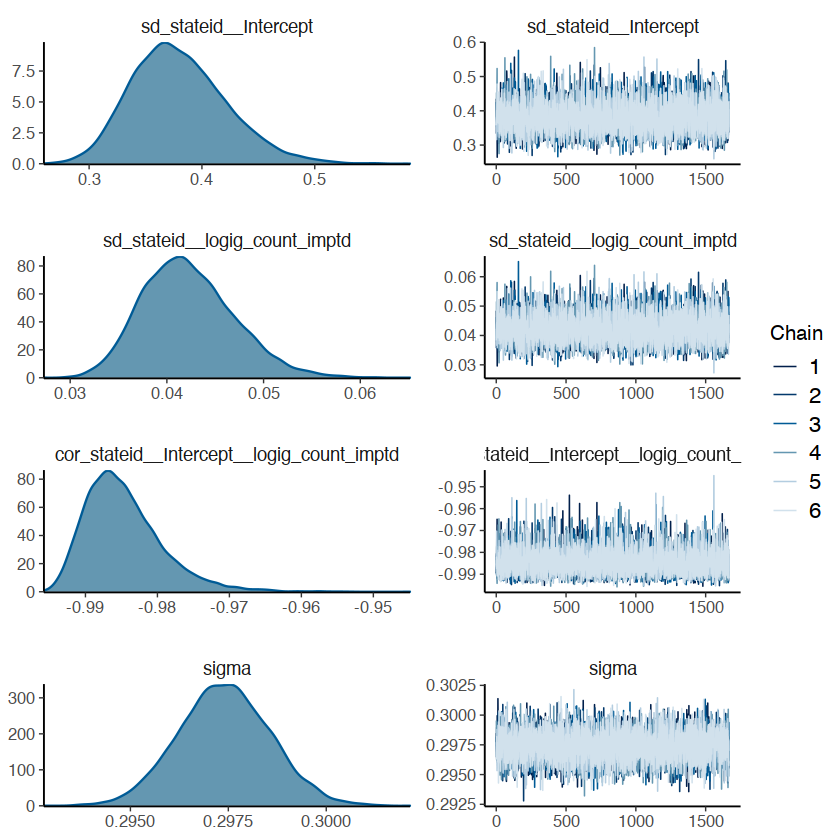

In [11]:
plot(models[[1]])

---

### Checking in-sample errors

In [17]:
results <- get_preds(models, dec, n_samples = 5000)
head(results)

zcta_id,year,ig_count,missing,lead,lag,ig_count_imptd,area_sqmi,geoid,chh,⋯,chh_density,state_name,state_abbrev,stateid,lprd_1,lu90_1,ll90_1,prd_1,u90_1,l90_1
<chr>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
01001,2010,7923,FALSE,7008,7665,7923,11.5044300,1001,7215,⋯,627.150000,Massachusetts,MA,25,8.915185,8.942341,8.888069,7444.1573,7649.0839,7245.0186
01002,2010,9533,FALSE,9500,9626,9533,55.0650400,1002,9910,⋯,179.969000,Massachusetts,MA,25,9.134585,9.167661,9.101315,9270.4265,9582.1873,8967.0808
01005,2010,1866,FALSE,1966,1803,1866,44.2621100,1005,1904,⋯,43.016480,Massachusetts,MA,25,7.554658,7.576414,7.532599,1909.6161,1951.6172,1867.9544
01007,2010,5415,FALSE,5552,5188,5415,52.6010100,1007,5595,⋯,106.366800,Massachusetts,MA,25,8.610895,8.634537,8.587041,5491.1615,5622.5284,5361.7233
01008,2010,444,FALSE,499,447,444,53.8019300,1008,503,⋯,9.349107,Massachusetts,MA,25,6.131391,6.164977,6.097219,460.0756,475.7901,444.6195
01009,2010,347,FALSE,378,319,347,0.8124942,1009,315,⋯,387.695100,Massachusetts,MA,25,5.977683,6.014777,5.940632,394.5253,409.4347,380.1753


In [18]:
log_errors <- rbind(
  get_errors(log(results$chh), log(results$ig_count_imptd), "raw infogroup"),
  get_errors(log(results$chh), results$lprd_1, desc1)
)
log_errors

,mean_y,sd_y,mean_yh,sd_yh,r,r2,rmse,mad,med_ad
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
raw infogroup,7.002049,1.763976,7.012992,1.657484,0.9821534,0.9646253,0.3403163,0.1858306,0.10969892
Bayesian random slopes with covariates,7.002049,1.763976,7.002073,1.738677,0.9857320,0.9716677,0.2969117,0.1507312,0.08151078


In [19]:
errors <- rbind(
  get_errors(results$chh, results$ig_count_imptd, "raw infogroup"),
  get_errors(results$chh, results$prd_1, desc1)
)
errors

,mean_y,sd_y,mean_yh,sd_yh,r,r2,rmse,mad,med_ad
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
raw infogroup,3589.93,5075.11,3235.817,4368.169,0.9876408,0.9754344,1083.1016,471.1035,100.00000
Bayesian random slopes with covariates,3589.93,5075.11,3566.534,5116.891,0.9922926,0.9846447,634.4938,277.7964,81.31163


---

### Use model to project to all years

Projecting to every zcta in the dataset for every year

In [12]:
years <- unique(acs_5$year)
years

[1] 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019

In [13]:
# This also takes a while, can read in below from a saved file
projections <- proj_by_year(acs_5, dec, models, "zcta_id", n_samples = 5000)

predictions for 2006

predictions for 2007

predictions for 2008

predictions for 2009

predictions for 2010

predictions for 2011

predictions for 2012

predictions for 2013

predictions for 2014

predictions for 2015

predictions for 2016

predictions for 2017

predictions for 2018

predictions for 2019



In [ ]:
saveRDS(projections, "../data/projections/zcta_final.rds")

In [24]:
projections <- readRDS("../data/projections/zcta_final.rds")
head(projections)

zcta_id,year,ig_count_imptd,chh,chh_moe,ig_count,missing,lead,lag,area_sqmi,⋯,chh_density,state_name,state_abbrev,stateid,lprd_1,lu90_1,ll90_1,prd_1,u90_1,l90_1
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
01001,2006,8116,NA,NA,7923,FALSE,7008,7665,11.5044300,⋯,627.150000,Massachusetts,MA,25,8.938187,8.965652,8.910683,7617.3773,7829.4852,7410.7184
01002,2006,11286,NA,NA,9533,FALSE,9500,9626,55.0650400,⋯,179.969000,Massachusetts,MA,25,9.297125,9.331903,9.262285,10906.6152,11292.6058,10533.1690
01005,2006,1984,NA,NA,1866,FALSE,1966,1803,44.2621100,⋯,43.016480,Massachusetts,MA,25,7.613534,7.635037,7.591920,2025.4241,2069.4476,1982.1151
01007,2006,5491,NA,NA,5415,FALSE,5552,5188,52.6010100,⋯,106.366800,Massachusetts,MA,25,8.624256,8.648087,8.600233,5565.0200,5699.2342,5432.9248
01008,2006,504,NA,NA,444,FALSE,499,447,53.8019300,⋯,9.349107,Massachusetts,MA,25,6.253133,6.285618,6.220770,519.6383,536.7961,503.0905
01009,2006,282,NA,NA,347,FALSE,378,319,0.8124942,⋯,387.695100,Massachusetts,MA,25,5.777739,5.817527,5.738185,323.0280,336.1399,310.5005


#### Make 5 year average of projections

In [14]:
projections$lig <- log(projections$ig_count_imptd)
projections_w_5year <- get_fiveyear(
    projections, 
    c("lprd_1", "prd_1", "ig_count_imptd", "lig", "lu90_1", "ll90_1", "u90_1", "l90_1"), 
    "zcta_id"
)

Averaging for 2010

Averaging for 2011

Averaging for 2012

Averaging for 2013

Averaging for 2014

Averaging for 2015

Averaging for 2016

Averaging for 2017

Averaging for 2018



In [15]:
table(projections_w_5year$year)


 2010  2011  2012  2013  2014  2015  2016  2017  2018 
32369 32199 32227 32222 32244 32252 32240 32246 32247 

---

### Get errors annually

#### 1. Errors comparing log(ACS) to log(infogroup)

In [16]:
# Note that moving forward, a year actually represents the average 
# of the year and the previous four years
years <- c(2011:2018)
projections_w_5year$lig_5year <- log(projections_w_5year$ig_count_imptd_5year)
log_errs_raw <- get_errors_by_year(projections_w_5year, years, "lig_5year")
log_errs_raw

,mean_y,sd_y,mean_yh,sd_yh,r,r2,rmse,mad,med_ad
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
errors_2011,6.989282,1.770551,7.025790,1.660158,0.9807195,0.9618108,0.3561761,0.2040748,0.1171862
errors_2012,6.988715,1.775456,7.033224,1.652361,0.9806387,0.9616523,0.3615653,0.2029685,0.1162751
errors_2013,6.988990,1.779193,7.045167,1.647164,0.9804983,0.9613770,0.3672705,0.2027163,0.1130374
errors_2014,6.988852,1.783051,7.055275,1.647193,0.9802940,0.9609763,0.3723163,0.2036328,0.1117222
errors_2015,6.989012,1.786711,7.059900,1.653760,0.9809036,0.9621719,0.3681698,0.2004695,0.1089585
errors_2016,6.990491,1.791657,7.064294,1.660733,0.9806547,0.9616836,0.3710886,0.2004252,0.1071606
errors_2017,6.993471,1.799474,7.065473,1.671089,0.9800222,0.9604435,0.3765802,0.2029870,0.1079325
errors_2018,6.994283,1.805109,7.067154,1.683737,0.9799340,0.9602707,0.3768439,0.2027757,0.1060184


#### 2. Errors comparing log(ACS) to log(adjusted infogroup)

In [17]:
log_errs_adj <- get_errors_by_year(projections_w_5year, years, "lprd_1_5year")
log_errs_adj

,mean_y,sd_y,mean_yh,sd_yh,r,r2,rmse,mad,med_ad
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
errors_2011,6.989282,1.770551,7.010877,1.744406,0.9836322,0.9675323,0.3197695,0.1754939,0.09447260
errors_2012,6.988715,1.775456,7.019456,1.736240,0.9834997,0.9672718,0.3228121,0.1736052,0.09266238
errors_2013,6.988990,1.779193,7.031897,1.731331,0.9832456,0.9667720,0.3276399,0.1744073,0.09325349
errors_2014,6.988852,1.783051,7.043032,1.731356,0.9829259,0.9661432,0.3332020,0.1767537,0.09442181
errors_2015,6.989012,1.786711,7.047594,1.739377,0.9831808,0.9666446,0.3319777,0.1764829,0.09640824
errors_2016,6.990491,1.791657,7.051837,1.747829,0.9826150,0.9655322,0.3384725,0.1799813,0.09843170
errors_2017,6.993471,1.799474,7.052889,1.758949,0.9819039,0.9641353,0.3460114,0.1846318,0.10110480
errors_2018,6.994283,1.805109,7.054343,1.772858,0.9815424,0.9634255,0.3503990,0.1885645,0.10465772


#### 3. Errors comparing ACS to raw infogroup

In [18]:
errs_raw <- get_errors_by_year(projections_w_5year, years, "ig_count_imptd_5year", log = FALSE)
errs_raw

,mean_y,sd_y,mean_yh,sd_yh,r,r2,rmse,mad,med_ad
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
errors_2011,3548.972,5006.202,3292.485,4447.790,0.9876569,0.9754662,962.9422,429.1736,110.6667
errors_2012,3559.935,5026.105,3295.879,4443.920,0.9886254,0.9773802,957.4735,428.2701,109.3333
errors_2013,3572.077,5046.205,3324.232,4482.780,0.9895575,0.9792241,922.6535,413.8075,109.1667
errors_2014,3587.885,5079.545,3359.625,4536.071,0.9899758,0.9800522,899.6555,403.7214,109.5000
errors_2015,3608.766,5123.255,3396.175,4597.950,0.9907308,0.9815476,870.5254,390.4409,108.5000
errors_2016,3634.405,5170.557,3432.537,4655.660,0.9911947,0.9824669,854.2697,381.1563,107.8333
errors_2017,3667.822,5223.541,3467.400,4713.258,0.9912346,0.9825460,855.6541,379.7057,107.2500
errors_2018,3695.328,5276.078,3513.566,4791.746,0.9915313,0.9831343,834.1454,369.6061,108.0000


#### 4. Errors comparing ACS to adjusted infogroup

In [19]:
errs_adj <- get_errors_by_year(projections_w_5year, years, "prd_1_5year", log = FALSE)
errs_adj

,mean_y,sd_y,mean_yh,sd_yh,r,r2,rmse,mad,med_ad
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
errors_2011,3548.972,5006.202,3632.668,5215.211,0.9922794,0.9846184,673.6616,302.1528,94.43113
errors_2012,3559.935,5026.105,3637.244,5213.375,0.9930065,0.9860618,638.3864,294.0626,94.18701
errors_2013,3572.077,5046.205,3671.321,5265.793,0.9935116,0.9870652,634.7288,296.0310,95.24650
errors_2014,3587.885,5079.545,3713.340,5335.270,0.9935770,0.9871952,655.1788,306.3604,97.31501
errors_2015,3608.766,5123.255,3757.774,5417.350,0.9937419,0.9875230,675.3235,316.2690,97.29747
errors_2016,3634.405,5170.557,3801.834,5492.355,0.9937291,0.9874975,698.3841,327.7336,99.35473
errors_2017,3667.822,5223.541,3843.180,5562.525,0.9935661,0.9871735,720.7885,338.8457,102.74163
errors_2018,3695.328,5276.078,3898.457,5660.761,0.9934940,0.9870303,760.1656,357.3605,104.82391


#### Compute average improvement across years and tracts

In [20]:
cat("Raw MAD:      ", mean(errs_raw$med_ad), "\n")
cat("Adjusted MAD: ", mean(errs_adj$med_ad), "\n")
mad_dec <- (mean(errs_adj$med_ad) - mean(errs_raw$med_ad)) / mean(errs_raw$med_ad)
cat("Difference:   ", mad_dec)

Raw MAD:       108.7812 
Adjusted MAD:  98.17467 
Difference:    -0.09750372

In [21]:
cat("Raw RMSE:      ", mean(errs_raw$rmse), "\n")
cat("Adjusted RMSE: ", mean(errs_adj$rmse), "\n")
rmse_dec <- (mean(errs_adj$rmse) - mean(errs_raw$rmse)) / mean(errs_raw$rmse)
cat("Difference:   ", rmse_dec)

Raw RMSE:       894.6649 
Adjusted RMSE:  682.0772 
Difference:    -0.2376172

#### Compute improvement yearly

In [22]:
round((log_errs_adj$med_ad - log_errs_raw$med_ad)/log_errs_raw$med_ad, 3)

[1] -0.194 -0.203 -0.175 -0.155 -0.115 -0.081 -0.063 -0.013

In [23]:
round((log_errs_adj$rmse - log_errs_raw$rmse)/log_errs_raw$rmse, 3)

[1] -0.102 -0.107 -0.108 -0.105 -0.098 -0.088 -0.081 -0.070

In [24]:
round((errs_adj$med_ad - errs_raw$med_ad)/errs_raw$med_ad, 3)

[1] -0.147 -0.139 -0.128 -0.111 -0.103 -0.079 -0.042 -0.029

In [25]:
round((errs_adj$rmse - errs_raw$rmse)/errs_raw$rmse, 3)

[1] -0.300 -0.333 -0.312 -0.272 -0.224 -0.182 -0.158 -0.089

#### Get share in error bands

In [27]:
projections_w_5year <- projections_w_5year %>%
    filter(year %in% c(2011:2018)) %>%
    mutate(
        acs_upper = chh + chh_moe,
        acs_lower = ifelse(chh - chh_moe <= 0, 1, chh - chh_moe),
        lacs_upper = log(acs_upper),
        lacs_lower = log(acs_lower),
        ladj_in_moe = case_when(
            lu90_1_5year <= lacs_upper & lu90_1_5year >= lacs_lower ~ 1,
            ll90_1_5year <= lacs_upper & ll90_1_5year >= lacs_lower ~ 1,
            lu90_1_5year <= lacs_upper & ll90_1_5year >= lacs_lower ~ 1,
            lu90_1_5year >= lacs_upper & ll90_1_5year <= lacs_lower ~ 1,
            TRUE ~ 0
        ),
        lraw_in_moe = case_when(
            lig_5year <= lacs_upper & lig_5year >= lacs_lower ~ 1,
            TRUE ~ 0
        ),
        ladj_ci_span = lu90_1_5year - ll90_1_5year,
        adj_in_moe = case_when(
            u90_1 <= acs_upper & u90_1 >= acs_lower ~ 1,
            l90_1 <= acs_upper & l90_1 >= acs_lower ~ 1,
            u90_1 <= acs_upper & l90_1 >= acs_lower ~ 1,
            u90_1 >= acs_upper & l90_1 <= acs_lower ~ 1,
            TRUE ~ 0
        ),
        raw_in_moe = case_when(
            ig_count_imptd_5year <= acs_upper & ig_count_imptd_5year >= acs_lower ~ 1,
            TRUE ~ 0
        ),
        adj_ci_span = u90_1_5year - l90_1_5year
    )
head(projections_w_5year)
cat("Proportion raw in ACS MOE: ", sum(projections_w_5year$raw_in_moe)/nrow(projections_w_5year), "\n")
cat("Proportion adj in ACS MOE: ", sum(projections_w_5year$adj_in_moe)/nrow(projections_w_5year), "\n")
cat("Mean adjusted CI span:     ", mean(projections_w_5year$adj_ci_span), "\n")
cat("Median adjusted CI span:   ", median(projections_w_5year$adj_ci_span), "\n")
cat("Mean ACS MOE span:         ", mean(projections_w_5year$acs_upper - projections_w_5year$acs_lower), "\n \n")

cat("Log Proportion raw in ACS MOE: ", sum(projections_w_5year$lraw_in_moe)/nrow(projections_w_5year), "\n")
cat("Log Proportion adj in ACS MOE: ", sum(projections_w_5year$ladj_in_moe)/nrow(projections_w_5year), "\n")
cat("Log Mean adjusted CI span:     ", mean(projections_w_5year$ladj_ci_span), "\n")
cat("Log Median adjusted CI span:   ", median(projections_w_5year$ladj_ci_span), "\n")
cat("Log Mean ACS MOE span:         ", mean(projections_w_5year$lacs_upper - projections_w_5year$lacs_lower), "\n \n")

zcta_id,lprd_1_5year,prd_1_5year,ig_count_imptd_5year,lig_5year,lu90_1_5year,ll90_1_5year,u90_1_5year,l90_1_5year,year,⋯,acs_upper,acs_lower,lacs_upper,lacs_lower,ladj_in_moe,lraw_in_moe,ladj_ci_span,adj_in_moe,raw_in_moe,adj_ci_span
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
01001,8.875492,7163.9410,7613.0000,8.937613,8.902342,8.848725,7359.0484,6974.5265,2011,⋯,7264,6768,8.890686,8.819961,1,0,0.05361686,1,0,384.52189
01002,9.182105,9738.6469,10033.6667,9.213701,9.216024,9.148707,10074.9498,9418.5186,2011,⋯,10070,8784,9.217316,9.080687,1,1,0.06731674,1,1,656.43120
01005,7.585277,1970.7911,1928.0000,7.564238,7.607106,7.563233,2014.2659,1927.8265,2011,⋯,2052,1732,7.626570,7.457032,1,1,0.04387337,1,1,86.43942
01007,8.602006,5444.4898,5366.3333,8.587900,8.625855,8.578114,5575.9086,5315.9186,2011,⋯,5771,5439,8.660601,8.601350,1,0,0.04774066,1,0,259.99004
01008,6.191846,490.3897,474.5000,6.162262,6.224923,6.158392,506.8343,474.2881,2011,⋯,530,416,6.272877,6.030685,1,1,0.06653114,1,1,32.54619
01009,5.915380,372.1729,326.6667,5.788940,5.953084,5.877134,386.4343,358.2299,2011,⋯,403,223,5.998937,5.407172,1,1,0.07594979,0,1,28.20443


Proportion raw in ACS MOE:  0.4762503 
Proportion adj in ACS MOE:  0.5715167 
Mean adjusted CI span:      205.5082 
Median adjusted CI span:    44.75156 
Mean ACS MOE span:          334.6415 
 
Log Proportion raw in ACS MOE:  0.4762503 
Log Proportion adj in ACS MOE:  0.6186903 
Log Mean adjusted CI span:      0.05149346 
Log Median adjusted CI span:    0.04641177 
Log Mean ACS MOE span:          0.4015046 
 


### Plots

Warning message:
“Removed 22030 rows containing non-finite values (stat_density_ridges).”
Warning message:
“Removed 18036 rows containing non-finite values (stat_density_ridges).”


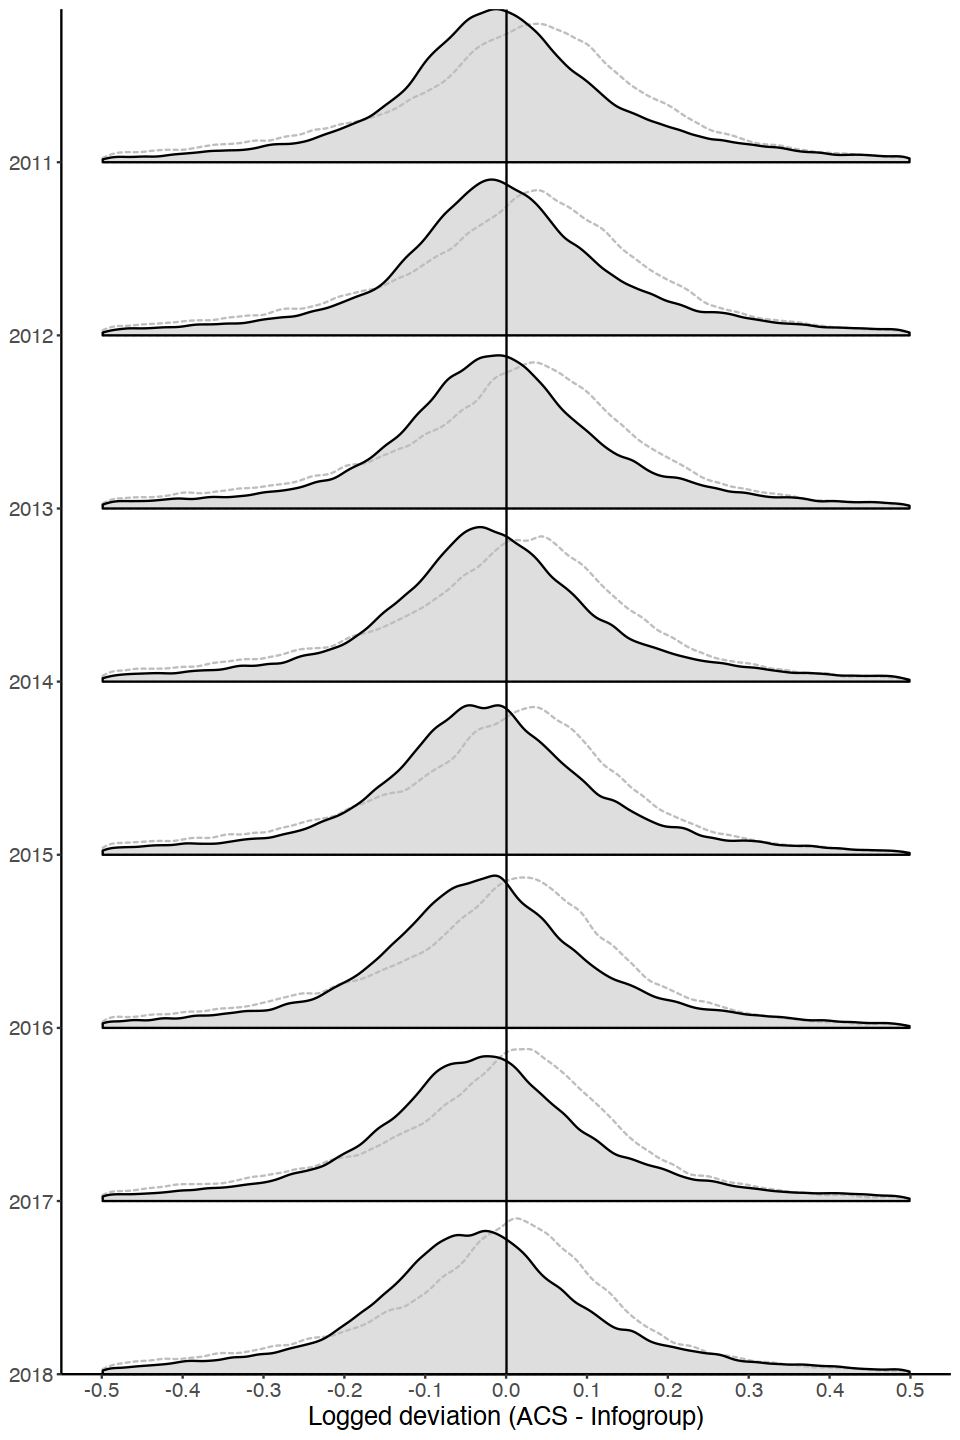

In [28]:
options(repr.plot.width=8, repr.plot.height=12)

projections_w_5year %>%
    mutate(dev = log(chh) - lprd_1_5year,
           dev2 = log(chh) - lig_5year) %>%
    ggplot(aes(x = dev, y = fct_rev(as_factor(year)))) +
     geom_density_ridges2(
        aes(x = dev2),
        fill = NA,
        color = "grey",
        linetype = "dashed",
        panel_scaling = TRUE,
        alpha = 0.5,
        scale = .9,
        bandwidth = 0.01
    ) +
    geom_density_ridges2(
        panel_scaling = FALSE,
        fill = "grey",
        alpha = .5,
        scale = .9,
        bandwidth = 0.01
    ) +
    geom_vline(xintercept = 0, color = 'black', linetype = "solid") +
    scale_x_continuous(
        limits = c(-.5, .5),
        name = "Logged deviation (ACS - Infogroup)",
        breaks = seq(-.5, .5, .1)
    ) +
    scale_y_discrete(expand = c(0, 0)) +
    theme_classic() +
    theme(
        text = element_text(size = 15),
        axis.title.y = element_blank()
    )

In [29]:
ggsave("../plots/zcta_distributions.png", height = 8, width = 6)

Warning message:
“Removed 22030 rows containing non-finite values (stat_density_ridges).”
Warning message:
“Removed 18036 rows containing non-finite values (stat_density_ridges).”


In [30]:
options(repr.plot.width=12, repr.plot.height=12)

plot_cases <- function(projections, zcta_sample) {
    projections %>%
        mutate("zctaname" = paste0(zcta_id, ", ", state_abbrev)) %>%
        filter(zcta_id %in% zcta_sample) %>%
        ggplot() +
            geom_line(aes(x = year, y = lprd_1_5year)) +
            geom_point(aes(x = year, y = lprd_1_5year)) +
            geom_ribbon(
                aes(x = year, ymin = ll90_1_5year, ymax = lu90_1_5year),
                alpha = 0.2
            ) +
            geom_line(
                aes(x = year, y = log(ig_count_imptd_5year)),
                linetype = 'dashed'
            ) +
            geom_line(
                aes(x = year, y = log(chh)),
                color = 'grey20'
            ) +
            geom_ribbon(
                aes(x = year, ymin = lacs_lower, ymax = lacs_upper),
                alpha = 0.4,
                fill = 'grey20'
            ) +
            facet_grid(. ~ zctaname) +
            scale_y_continuous(name = "Log (Population)") +
            scale_x_continuous(breaks = seq(2012, 2016, 2)) +
            theme_classic() +
            theme(
                text = element_text(size = 15),
                axis.title.x = element_blank()
            )
}

`summarise()` ungrouping output (override with `.groups` argument)



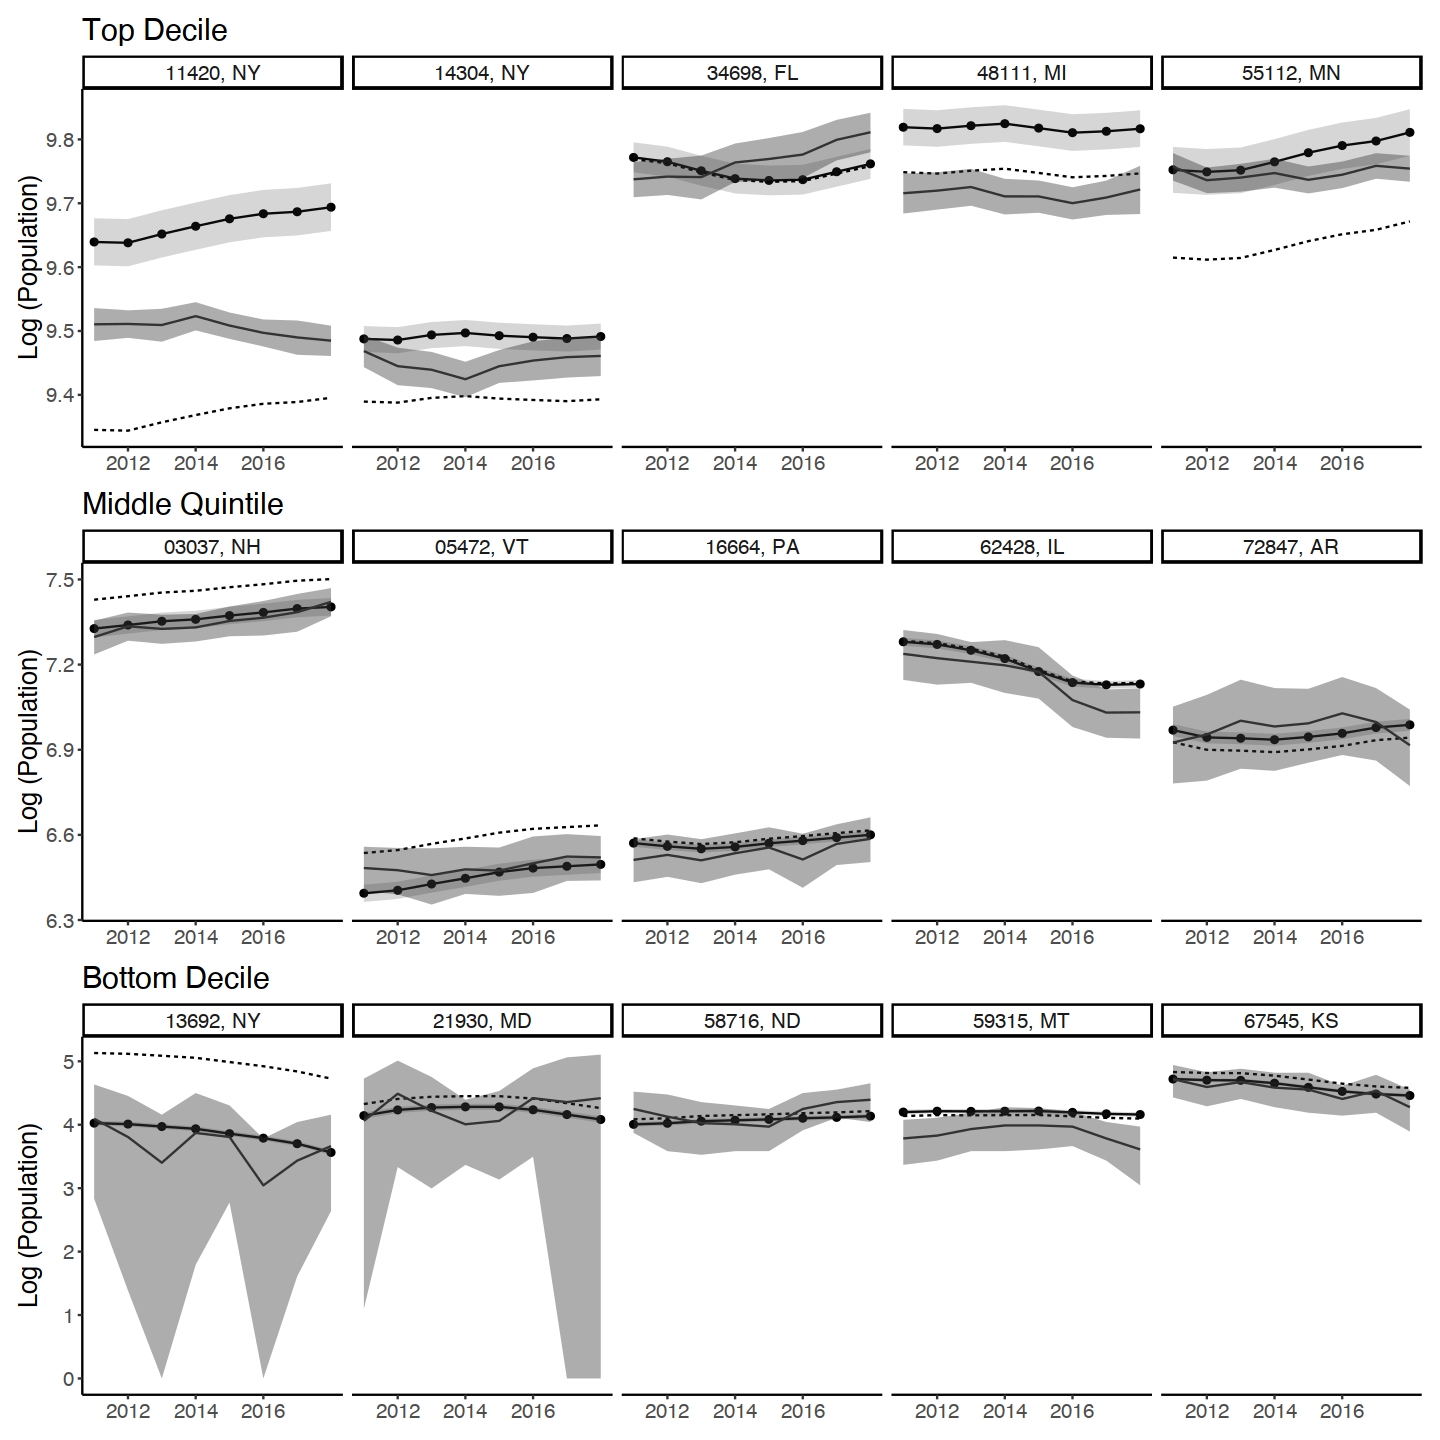

In [31]:
# split the data by population decile
zctaid_decile <- projections_w_5year %>%
    group_by(zcta_id) %>%
    summarize(acs_mean = mean(log(chh))) %>%
    mutate(acs_quartile = quantcut(acs_mean, q = 10, na.rm = TRUE))
levels(zctaid_decile$acs_quartile) <- c(1:10)

# first row should be top decile
top_zcta_decile <- zctaid_decile %>%
    filter(acs_quartile == '10') %>%
    sample_n(5) %>%
    .$zcta_id %>%
    unique()
p1 <- plot_cases(projections_w_5year, top_zcta_decile) +
    ggtitle("Top Decile")

# second row from middle quintile
mid_zcta_quintile <- zctaid_decile %>%
    filter(acs_quartile %in% c("5", "6")) %>%
    sample_n(5) %>%
    .$zcta_id %>%
    unique()
p2 <- plot_cases(projections_w_5year, mid_zcta_quintile) +
    ggtitle("Middle Quintile")

# bottom row from lowest decile
bot_zcta_decile <- zctaid_decile %>%
    filter(acs_quartile == 1) %>%
    sample_n(5) %>%
    .$zcta_id %>%
    unique()
p3 <- plot_cases(projections_w_5year, bot_zcta_decile) +
    ggtitle("Bottom Decile")

p1 / p2 / p3

In [32]:
ggsave("../plots/zcta_random_sample.png", device = "png", height = 10, width = 10)